# silver price

## load tha data

In [873]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto
import scipy

# Load dataset
df = pd.read_csv('silver.csv')
df.head()

,Date,USD
0,2022-04-21,24.645
1,2022-04-20,25.200
2,2022-04-19,25.915
3,2022-04-14,25.655
4,2022-04-13,25.640


## Handle missing values

Reads the silver price dataset (silver.csv) into a Pandas DataFrame.    
Converts the Date column into datetime format.  
Fills in any missing values using forward fill (ffill()).   
Computes daily percentage changes in silver price to analyze returns.   
Drops any missing values from the computed returns (rate_change).   

In [874]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Handle missing values (forward-fill method)
df['USD'] = df['USD'].ffill()
# Compute rate changes (percentage change in Silver price)
df['rate_change'] = df['USD'].pct_change()
# Remove NaN from first difference
df = df.dropna()

## Plot Silver Prices

Plots silver price in USD over time.    
Helps visualize major price spikes and crashes (e.g., around 1980 and 2011).

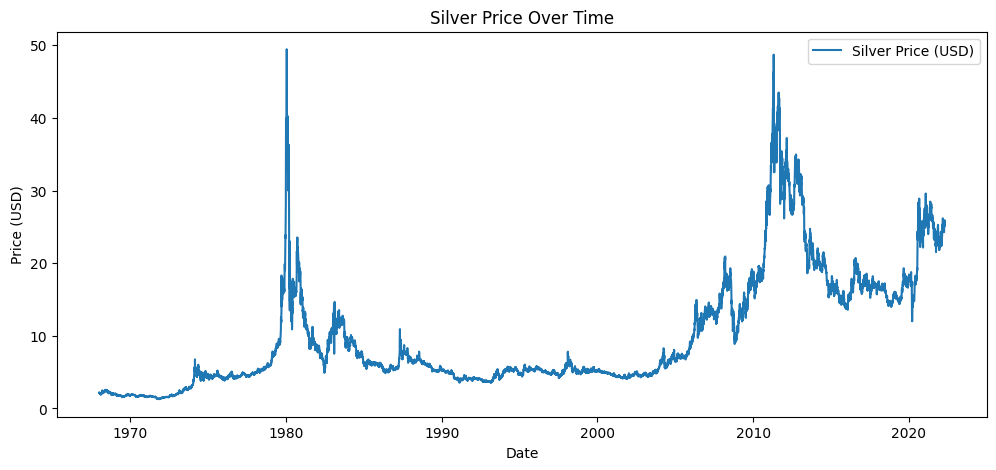

In [875]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['USD'], label='Silver Price (USD)')
plt.title('Silver Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Daily Returns Over Time

Plots daily percentage changes.     
Highlights volatility and extreme price movements.  
The red dashed line at 0% helps see when the price is increasing or decreasing. 

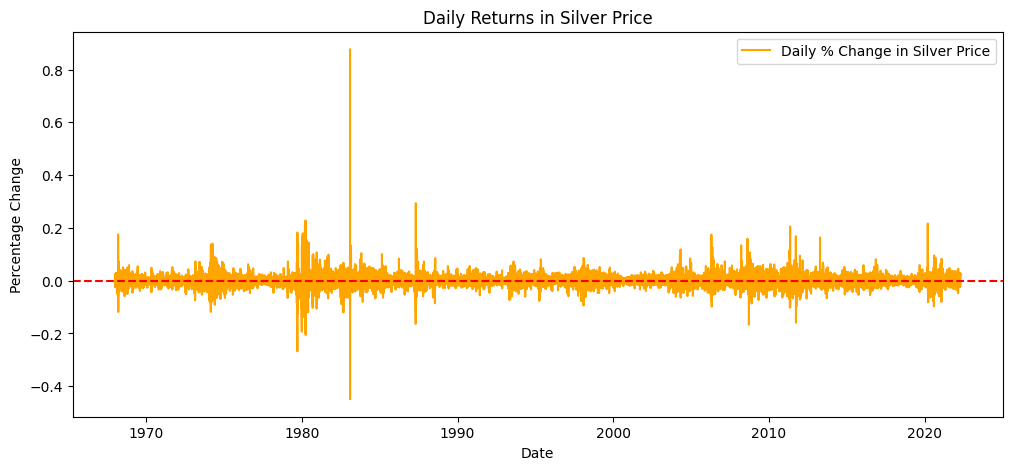

In [876]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['rate_change'], label='Daily % Change in Silver Price', color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Daily Returns in Silver Price')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

Daily Returns Over Time shows percentage changes in silver price (daily returns), highlighting volatility.

## Distribution of Returns

Shows the distribution of daily returns.    
Tall central peak suggests most days have small price changes.  
Fat tails (values far from 0) indicate occasional extreme price moves.  

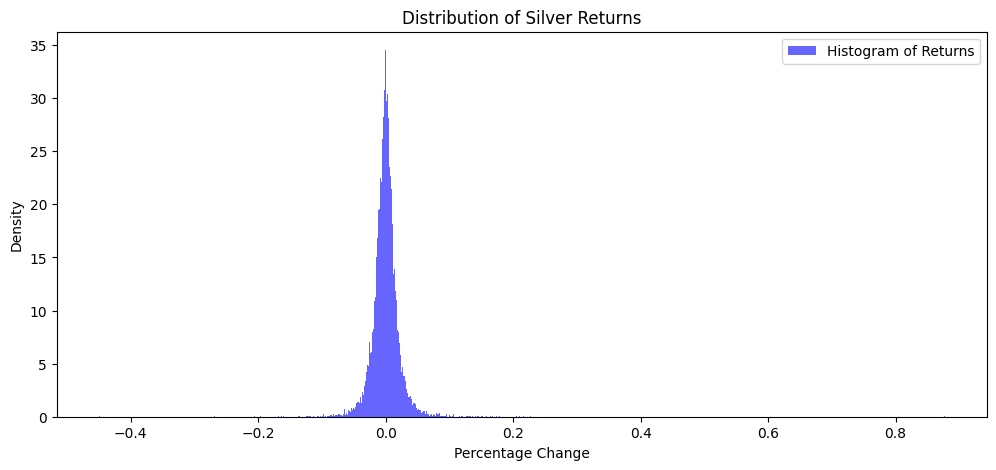

In [877]:
plt.figure(figsize=(12,5))
plt.hist(df['rate_change'], bins=1000, density=True, alpha=0.6, color='b', label='Histogram of Returns')
plt.title('Distribution of Silver Returns')
plt.xlabel('Percentage Change')
plt.ylabel('Density')
plt.legend()
plt.show()

Silver price returns have fat tails → large price swings happen more often than a normal distribution would predict.

---

## Block Maxima & Minima

Groups data into 2-week blocks and selects:     
The maximum return (biggest price hike).    
The minimum return (biggest price cut).     

In [878]:
# Block Maxima Method for hikes (positive changes)
df['year_month'] = df['Date'].dt.to_period('2W')
block_maxima_hikes = df.groupby('year_month')['rate_change'].max()

# Block Minima Method for cuts (negative changes)
block_minima_cuts = df.groupby('year_month')['rate_change'].min()

## Fitting the Generalized Extreme Value (GEV) Distribution

1. Fits the GEV distribution to:   
- Maxima (Hikes) → Models large positive returns.
- Minima (Cuts) → Models large negative returns.    
2. GEV Parameters:
- Shape (ξ): Determines tail heaviness.
- Location (μ): Center of distribution.
- Scale (σ): Spread of extreme values.

If the shape parameter ξ > 0, the distribution has a heavy tail (extreme events are more likely).   
If ξ < 0, the distribution has a short tail (extremes are limited).     
If ξ ≈ 0, the distribution resembles a Gumbel (light-tailed) distribution.

3. Q-Q Plots for GEV Fit    

- Compare actual quantiles vs. theoretical quantiles.     
- If the points closely follow the diagonal line, the GEV model fits well.    
- Deviations from the line suggest the model may not perfectly capture the extremes.

GEV Parameters (Hikes - Shape, Location, Scale): (np.float64(-0.15354816679349959), np.float64(0.012095546689784797), np.float64(0.011439896325541198))
GEV Parameters (Cuts - Shape, Location, Scale): (np.float64(-0.03885947296242869), np.float64(0.012921076719469422), np.float64(0.012278247016165318))


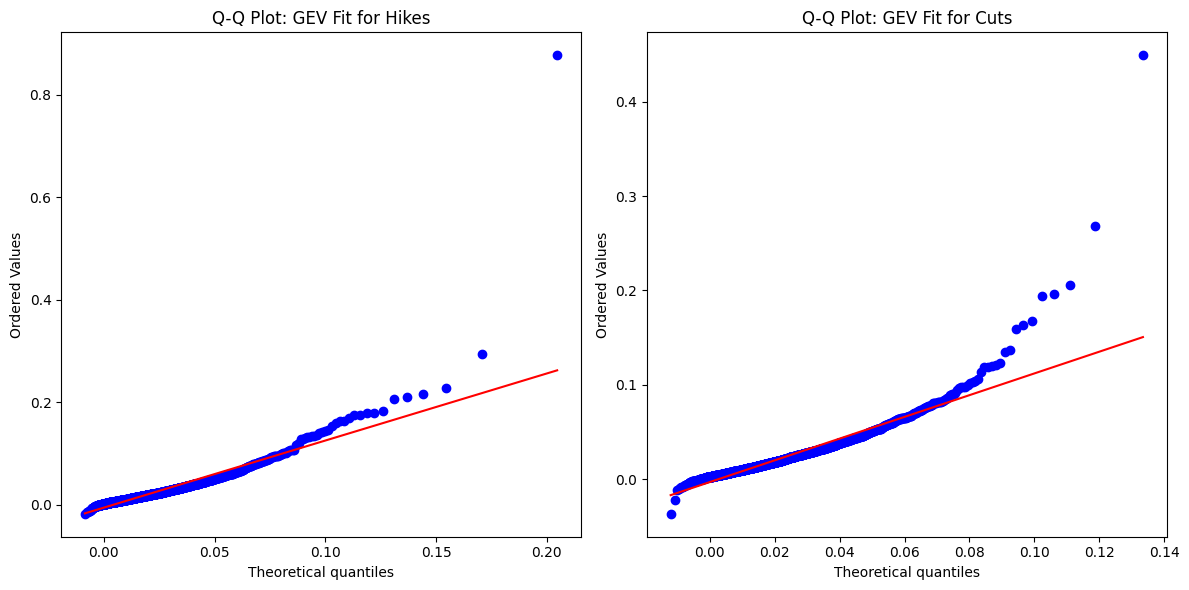

In [879]:
# Fit GEV Distribution for hikes
gev_params_hikes = genextreme.fit(block_maxima_hikes)
print("GEV Parameters (Hikes - Shape, Location, Scale):", gev_params_hikes)

# Fit GEV Distribution for cuts
gev_params_cuts = genextreme.fit(-block_minima_cuts)  # Negate values to fit correctly
print("GEV Parameters (Cuts - Shape, Location, Scale):", gev_params_cuts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Q-Q Plot for Block Maxima Hikes
scipy.stats.probplot(block_maxima_hikes, dist=genextreme, sparams=gev_params_hikes, plot=axes[0])
axes[0].set_title("Q-Q Plot: GEV Fit for Hikes")

# Q-Q Plot for Block Minima Cuts
scipy.stats.probplot(-block_minima_cuts, dist=genextreme, sparams=gev_params_cuts, plot=axes[1])
axes[1].set_title("Q-Q Plot: GEV Fit for Cuts")

# Adjust layout
plt.tight_layout()
plt.show()

## Histogram vs. Fitted GEV Distribution

- Histograms compare the actual extreme returns with the GEV model.   
- Red curve shows the fitted distribution.    
- A good fit means GEV is a reasonable model for silver price hikes & cuts.   

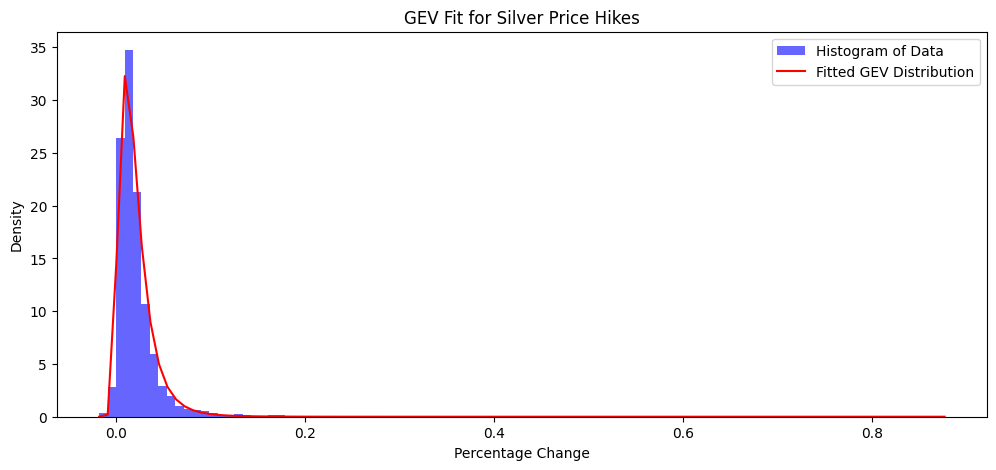

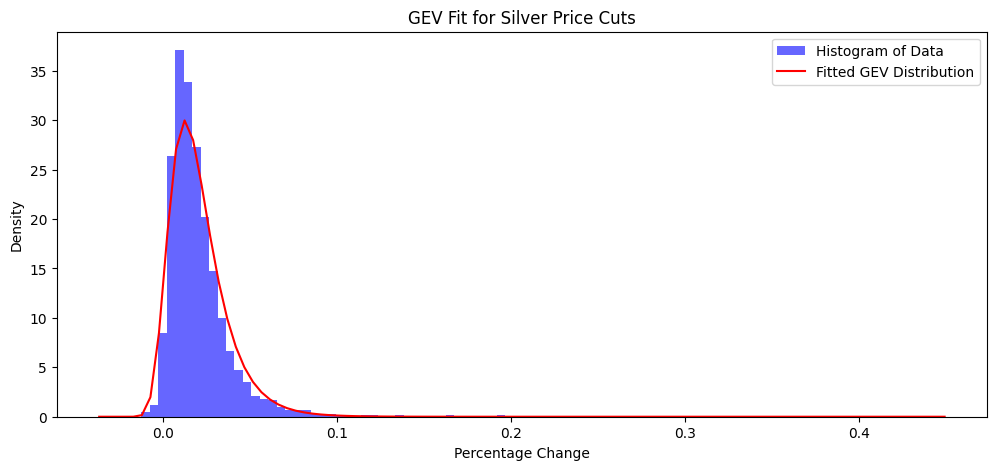

In [880]:
# Visualizing the Fitted GEV Distribution
def plot_gev_fits(data, gev_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genextreme.pdf(x, *gev_params)
    plt.hist(data, bins=100, density=True, alpha=0.6, color='b', label='Histogram of Data')
    plt.plot(x, pdf, 'r-', label='Fitted GEV Distribution')
    plt.title(title)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gev_fits(block_maxima_hikes, gev_params_hikes, 'GEV Fit for Silver Price Hikes')
plot_gev_fits(-block_minima_cuts, gev_params_cuts, 'GEV Fit for Silver Price Cuts')

## Peak Over Threshold (POT) Method Using GPD

1. Identifying Extreme Events
- Sets a threshold at 90th percentile for hikes (positive spikes).
- Sets a threshold at 10th percentile for cuts (negative spikes).
- Extracts only extreme events beyond these thresholds.

2. Fitting the Generalized Pareto Distribution (GPD)
- GPD is used for modeling extreme exceedances.
- Like GEV, it has shape, location, and scale parameters.

3. Q-Q Plots for GPD Fit
- Again, checks how well theoretical and observed quantiles align.
- A good fit means the GPD accurately models extreme silver price jumps.

GPD Parameters (Hikes - Shape, Location, Scale): (np.float64(0.3247072616860175), np.float64(0.020592484964940504), np.float64(0.012510560235295606))
GPD Parameters (Cuts - Shape, Location, Scale): (np.float64(0.13233156255394798), np.float64(0.021177685887371248), np.float64(0.013020573938509951))


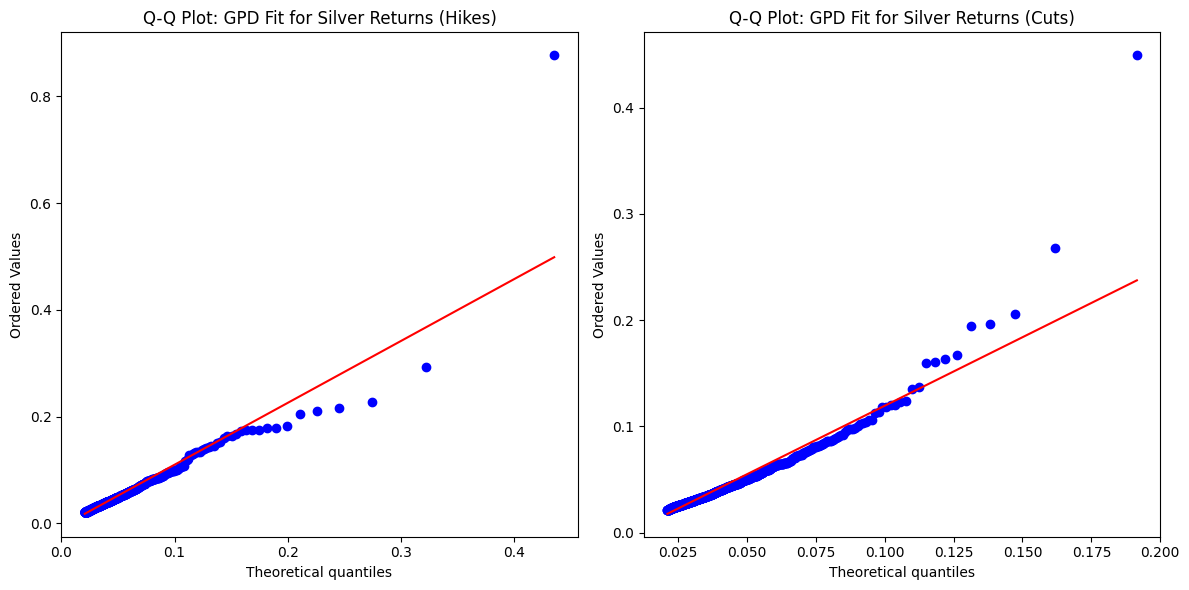

In [881]:
# Peak Over Threshold (POT) Method
threshold_pos = df['rate_change'].quantile(0.90)
extreme_hikes = df[df['rate_change'] > threshold_pos]['rate_change']
gpd_params_hikes = genpareto.fit(extreme_hikes)
print("GPD Parameters (Hikes - Shape, Location, Scale):", gpd_params_hikes)

threshold_neg = df['rate_change'].quantile(0.10)
extreme_cuts = df[df['rate_change'] < threshold_neg]['rate_change']
gpd_params_cuts = genpareto.fit(-extreme_cuts)
print("GPD Parameters (Cuts - Shape, Location, Scale):", gpd_params_cuts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Q-Q Plot for GPD Fit (Extreme Hikes)
scipy.stats.probplot(extreme_hikes, dist=genpareto, sparams=gpd_params_hikes, plot=axes[0])
axes[0].set_title("Q-Q Plot: GPD Fit for Silver Returns (Hikes)")

# Q-Q Plot for GPD Fit (Extreme Cuts)
scipy.stats.probplot(-extreme_cuts, dist=genpareto, sparams=gpd_params_cuts, plot=axes[1])
axes[1].set_title("Q-Q Plot: GPD Fit for Silver Returns (Cuts)")

# Adjust layout
plt.tight_layout()
plt.show()

## Histogram vs. Fitted GPD Distribution
- Shows how well GPD captures the tail behavior.
- Helps predict the likelihood of future extreme hikes/cuts.

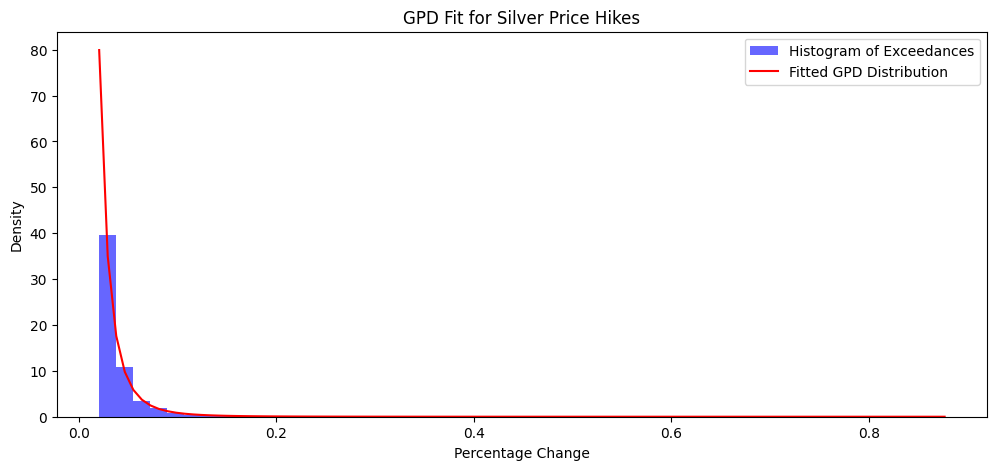

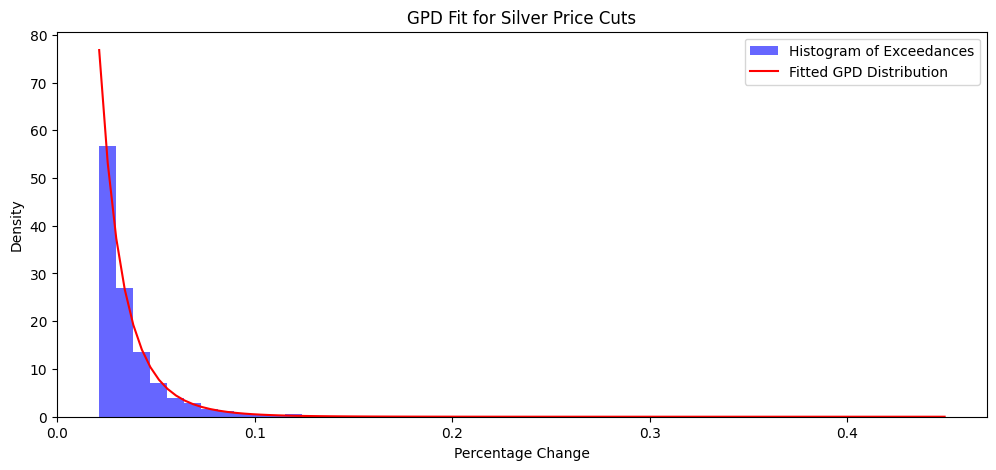

In [882]:
# Visualizing the Fitted GPD Distribution
def plot_gpd_fits(data, gpd_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genpareto.pdf(x, *gpd_params)
    plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label='Histogram of Exceedances')
    plt.plot(x, pdf, 'r-', label='Fitted GPD Distribution')
    plt.title(title)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gpd_fits(extreme_hikes, gpd_params_hikes, 'GPD Fit for Silver Price Hikes')
plot_gpd_fits(-extreme_cuts, gpd_params_cuts, 'GPD Fit for Silver Price Cuts')